In [1]:
import math
import copy
import random
from turtle import forward
from typing import Optional, Tuple, List, Union

import torch
from torch import Tensor, nn

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

/opt/homebrew/Caskroom/miniforge/base/envs/transformers_dev/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Differentiable TopK-Pooling

At each layer only $k$ token-embeddings are selected and passed to the next layer.

To make this operation differentiable it cannot use a hard selection scheme.

The authors propose a an algorithm which uses two steps:

1. Sorting
   * The embeddings passed into the current layer are scored using a linear operation (e.g. dot product)
   * The embeddings get sorted according to their score
   * Question: Sorting is a non-differentiable or partially non-differentiable?
   * Note: After selection the embeddings are re-arranged according to their original order????? This does not make any sense since they are positionally encoded???

In [2]:
x = torch.randint(0, 1000, (16, 512, 128))

In [3]:
torch.sort(x).indices

tensor([[[126,  35, 118,  ...,  60,  71,  83],
         [ 84,   6,  77,  ...,  45,  26,  21],
         [ 31,  27, 112,  ...,  56,  90,  16],
         ...,
         [ 30,  34,  86,  ...,  94,  69, 109],
         [ 73, 112, 111,  ..., 105,  72,  57],
         [ 57,   3,  25,  ...,  94, 127, 121]],

        [[ 64, 116,  34,  ...,  56,  46,  55],
         [ 73, 116,  44,  ...,  12,  55,  49],
         [ 62,  79,  31,  ...,  37,   3, 113],
         ...,
         [ 30,  43,  29,  ...,   9, 106,  75],
         [ 77,  60,  95,  ..., 105, 125,  52],
         [ 71,  48, 122,  ..., 124, 113,  83]],

        [[ 15,  43,  42,  ...,  36, 127,  12],
         [ 64,  47,  86,  ..., 106, 120,  91],
         [ 17,  84,  10,  ...,  69,  97,  52],
         ...,
         [ 68,  80,  66,  ..., 120,  24,  65],
         [126,  99,  97,  ...,  55,  49,  92],
         [ 68, 120,   5,  ...,  74, 107,  80]],

        ...,

        [[ 73,  18,  85,  ..., 122,  29,  56],
         [101,  50,   4,  ...,  96,   7,  97]

In [4]:
def peaked_softmax(x: Tensor, alpha: float = 0.1, dim: int = 0):
    x = x * alpha
    softmax = nn.Softmax(dim=dim)
    return softmax(x)


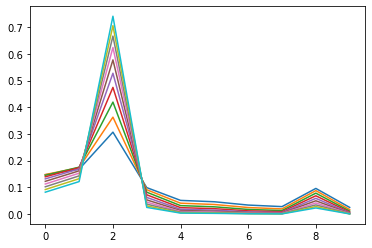

In [5]:
x = torch.randn(10)
for i in torch.linspace(1, 3, 10):
    plt.plot(peaked_softmax(x, alpha=i.item()).numpy())

In [6]:
class TopKPooler(nn.Module):

    def __init__(self, embedding_dim: int) -> None:
        super().__init__()
        self.scorer = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, embeddings: Tensor):
        """_summary_

        Args:
            embeddings (Tensor): tensor of shape (batch_size, n_embeddings,
        """
        # 1. Score embeddings
        scores = self.scorer(embeddings)
        
        # 2. Sort embeddings according to their score in descending order
        embeddings_sorted, scores_sorted = self.sort_embeddings(embeddings=embeddings, scores=scores)

        # 3. Create new tensors with pairs of embeddings and scores
        # Create embeddings pairs

        middle_idx = int(embeddings.size(1) // 2)
        #print(middle_idx)

        left_embeddings, right_embeddings = embeddings_sorted[:, :middle_idx, :], embeddings_sorted[:, middle_idx:, :]
        embedding_pairs = torch.cat((left_embeddings.unsqueeze(3), right_embeddings.flip(1).unsqueeze(3)), dim=3)
        #print(embedding_pairs.size())  # shape: bs, seqlen // 2, n_dim, 2

        # Create score pairs

        left_scores, right_scores = scores_sorted[:, :middle_idx, :], scores_sorted[:, middle_idx:, :]
        score_pairs = torch.cat((left_scores.unsqueeze(3), right_scores.flip(1).unsqueeze(3)), dim=3)
        #print(score_pairs.size())  # shape: bs, seqlen // 2, 1, 2

        score_pairs_softmaxed = peaked_softmax(score_pairs, alpha=5.0, dim=3)
        #print(score_pairs_softmaxed.size())

        new_embeddings = (embedding_pairs * score_pairs_softmaxed).sum(dim=3)
        #print(new_embeddings.size())
        return new_embeddings    
    
    def sort_embeddings(self, embeddings: Tensor, scores: Tensor):
        """Sorts the embeddings and score according to their score in descending order

        Args:
            embeddings (Tensor): tensor of shape (batch_size, n_embeddings, n_dims)
            scores (Tensor): (batch_size, n_embeddings, 1)

        Returns:
            _type_: Sorted embeddings and scores
        """
        sort_idc = scores.sort(descending=True, dim=1).indices
        #print(sort_idc.size())
        
        embeddings_sorted = self.sort_by_indices(embeddings, sort_idc)  #???
        #print(embeddings_sorted.size())
        
        scores_sorted = self.sort_by_indices(scores, sort_idc)  #???
        #print(scores_sorted.size())
        
        return embeddings_sorted, scores_sorted
    
    @staticmethod
    def sort_by_indices(embeddings, indices):
        sorted_batches = []
        for batch_embeddings, batch_scores in zip(embeddings, indices):
            sorted_batches.append(batch_embeddings[batch_scores.reshape(-1)].unsqueeze(0))
        return torch.cat(sorted_batches, dim=0)

            

In [7]:
n_layers = torch.log2(torch.tensor(512)).long().item()

pyramid = nn.Sequential(*(
    TopKPooler(embedding_dim=768)
    for _ in range(n_layers)
))
pyramid

Sequential(
  (0): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (1): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (2): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (3): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (4): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (5): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (6): TopKPooler(
    (scorer): Sequential(
      (0): Linear(in_features=768, out_features=1, bias=True)
      (1): Sigmoid()
    )
  )
  (7): TopKPooler(
   

In [8]:
src = torch.randn(8, 512, 768)
trgt = src[:, 64, :]
print(src.size())
print(trgt.size())

torch.Size([8, 512, 768])
torch.Size([8, 768])


In [9]:
out = pyramid(src)
out.size()

torch.Size([8, 1, 768])

In [10]:
optim = torch.optim.SGD(params=pyramid.parameters(), lr=0.1)
pbar = tqdm(list(range(10)))
for _ in pbar:
    out = pyramid(src).squeeze(1)
    loss_fct = nn.MSELoss()
    loss = loss_fct(out, trgt)
    pbar.set_description(f"Loss: {round(loss.item(), 4)}")
    loss.backward()
    optim.step()
    optim.zero_grad()


Loss: 1.0241: 100%|██████████| 10/10 [00:00<00:00, 17.70it/s]


In [11]:
out = pyramid(src).squeeze(1)
print(out)
print(trgt)

tensor([[-0.0130, -0.0132, -0.0248,  ...,  0.0326,  0.0155, -0.0780],
        [ 0.0190, -0.0462,  0.0032,  ...,  0.1164,  0.0172, -0.0266],
        [-0.0804, -0.0569,  0.0899,  ...,  0.0041,  0.0285,  0.0008],
        ...,
        [-0.0421, -0.0167, -0.0780,  ..., -0.0314,  0.0258,  0.0302],
        [ 0.0597,  0.0070,  0.0212,  ...,  0.0475, -0.0019,  0.0909],
        [ 0.0774,  0.0093, -0.0705,  ...,  0.0676, -0.1519,  0.0094]],
       grad_fn=<SqueezeBackward1>)
tensor([[-0.0339,  1.4042, -0.3040,  ..., -0.2899, -0.6973,  2.1442],
        [ 0.2529, -0.3199, -1.4702,  ..., -0.9236, -0.9293, -1.3260],
        [ 0.2001,  0.3252,  1.4340,  ..., -0.4139, -2.4138, -0.2354],
        ...,
        [ 2.2844, -0.8556, -1.4669,  ...,  0.0603, -1.4777, -0.1049],
        [ 0.5687, -0.3360,  0.8763,  ...,  1.2276,  0.3434, -0.0869],
        [ 1.7095, -0.2965, -1.5525,  ...,  0.1427, -0.2177, -0.4839]])


In [12]:
trgt

tensor([[-0.0339,  1.4042, -0.3040,  ..., -0.2899, -0.6973,  2.1442],
        [ 0.2529, -0.3199, -1.4702,  ..., -0.9236, -0.9293, -1.3260],
        [ 0.2001,  0.3252,  1.4340,  ..., -0.4139, -2.4138, -0.2354],
        ...,
        [ 2.2844, -0.8556, -1.4669,  ...,  0.0603, -1.4777, -0.1049],
        [ 0.5687, -0.3360,  0.8763,  ...,  1.2276,  0.3434, -0.0869],
        [ 1.7095, -0.2965, -1.5525,  ...,  0.1427, -0.2177, -0.4839]])

In [13]:
torch.randn(16, 512, 1).squeeze(2).size()

torch.Size([16, 512])

In [14]:
e = torch.tensor([
    [
        [0.1, 1.9],
        [0.0, 0.5],
        [0.7, 0.9]
    ],
    [
        [0.0, 0.0],
        [0.0, 0.5],
        [0.7, 0.9]
    ]
])
print(e.size())

s = torch.tensor([
    [
        [0],
        [2],
        [1]
    ],
    [
        [2],
        [1],
        [0]
    ],
])
print(s.size())

torch.Size([2, 3, 2])
torch.Size([2, 3, 1])


In [15]:
torch.arange(10).repeat(2).reshape(2, -1).flip(1)

tensor([[9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
        [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]])

# Model Architecture

* Pyramdion only serves as encoder model?
* Which architecture to use for decoder?

In [16]:
from transformers import PyramidionsConfig, PyramidionsModel, RobertaTokenizer

In [19]:
config = PyramidionsConfig()
config.update({"num_hidden_layers": 9})
print(config)
model = PyramidionsModel(config)
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model.resize_token_embeddings(len(tokenizer))

PyramidionsConfig {
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "pyramidions",
  "num_attention_heads": 12,
  "num_hidden_layers": 8,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.19.0.dev0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



Embedding(50265, 768)

In [20]:
model(**tokenizer("Hallo", padding="max_length", return_tensors="pt"))

Attention mask size: torch.Size([1, 1, 1, 512])
!
Attention mask size: torch.Size([1, 1, 1, 256])
!
Attention mask size: torch.Size([1, 1, 1, 128])
!
Attention mask size: torch.Size([1, 1, 1, 64])
!
Attention mask size: torch.Size([1, 1, 1, 32])
!
Attention mask size: torch.Size([1, 1, 1, 16])
!
Attention mask size: torch.Size([1, 1, 1, 8])
!
Attention mask size: torch.Size([1, 1, 1, 4])
!


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.5434,  0.0029, -0.3336,  ...,  0.5218,  2.0407,  0.7848],
         [-0.4420, -0.2242,  0.0339,  ...,  0.5649,  1.8746,  0.8195]]],
       grad_fn=<SumBackward1>), pooler_output=tensor([[ 2.5442e-01, -3.9056e-01,  5.7746e-01,  4.6337e-01,  6.9603e-01,
          7.4548e-01, -2.5723e-01,  3.8278e-01,  1.6209e-01,  1.4187e-01,
         -2.1032e-01, -4.1698e-02, -4.8655e-02, -4.5556e-02,  2.6417e-01,
          3.4155e-01,  3.5491e-01, -3.9734e-01, -8.7051e-02,  2.7474e-01,
         -7.2390e-01, -1.3611e-01,  3.5677e-02, -1.7436e-01,  9.5352e-02,
         -8.2275e-03, -7.3312e-01,  2.7476e-01,  2.5937e-01, -2.5853e-01,
         -3.1858e-02,  7.0243e-01, -5.2187e-01,  3.1224e-02, -1.0359e-03,
         -3.1398e-01, -5.2337e-01, -2.9901e-01, -5.7466e-01,  4.6077e-01,
         -6.8926e-01, -6.8369e-01, -3.1370e-01,  1.9323e-01,  4.6635e-01,
          6.1563e-02, -7.3941e-01,  5.7603e-01, -5.9542e-01,  8.5028e-01,
       

In [ ]:
torch.randn(1, 1, 1, 512)[...,:312].size()

torch.Size([1, 1, 1, 312])